# Matching placenames

**In this notebook an automated approach is presented for matching placenames found in lists on land use to georeferenced placenames from historical maps. It provides a way to make information from historical documents spatialy explicit. The notebook is part of a set of three notebooks which can all be found on [GitHub](https://github.com/Yegberink/VOC_land_use).**


## Load data

Load the data with this approach. Update the file paths according to your data structure. To properly run the code, your documents should be in a similar format as placenames.gpkg and datasets.xlsx. You can find the datasets on [GitHub](https://github.com/Yegberink/VOC_land_use) for reference. In this codeblock also the regions are specified. In this case these are the overarching regions of which maps are found. The packages are also loaded in this codeblock. Uncomment the install if (some of) the are not yet installed.



In [53]:
#pip install geopandas pandas fuzzywuzzy scikit-learn numpy python-Levenshtein

In [155]:
# Load packages
import geopandas as gpd
import pandas as pd
import os
from fuzzywuzzy import fuzz
from sklearn.cluster import DBSCAN
import numpy as np
from collections import Counter
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import pickle


# Set the directory
path = "/Users/Yannick/Documents/LUC_github/VOC_land_use"
os.chdir(path)

#load the georeferenced placenames
placenames_maps = gpd.read_file("maps/placenames/placenames.gpkg").dropna(subset=['geometry'])

# Load the Excel file
xls = pd.ExcelFile("output/results/datasets.xlsx")

#Get all sheetnames from the file
sheet_names = xls.sheet_names

# Specify some unwanted sheets (update according to your data structure)
unwanted_sheets = ["short_summary_of_datasets", "template_information"]

#Filter out unwanted sheets
filtered_sheet_names = [name for name in sheet_names if name not in unwanted_sheets]

# Initialize an empty list to store each document's cleaned dataset
all_documents = []

# Loop through the remaining sheet names to load, clean, and append each dataset
for document_number in filtered_sheet_names:
    
    # Load data from the current sheet
    dataset = pd.read_excel(xls, sheet_name=document_number)
    
    # Remove NaN values from the 'Village' column and ensure unique village names within this dataset
    dataset_cleaned = dataset.dropna(subset=['Village']).drop_duplicates(subset=['Village'])
    
    # Add a new column 'sheet_name' to track which sheet the data came from
    dataset_cleaned['sheet_name'] = document_number
    
    # Append the cleaned dataset to the list
    all_documents.append(dataset_cleaned)

# Concatenate all datasets into one DataFrame
combined_dataset = pd.concat(all_documents, ignore_index=True)

# Generate sequential IDs for the grouped dataset
combined_dataset['ID'] = range(1, len(combined_dataset) + 1)

#Clean up the dataset to keep only columns of interest
columns_to_keep = ['ID', 'Year', 'Village', 'Region1', 'Region2', 'quantity', 'unit', 'sheet_name']
combined_dataset = combined_dataset[columns_to_keep]

# Initiate the regions
regions = ['happitigam corle', 'hina corle', 'alloetcoer corle']

print("done loading data")

done loading data


## Clean transcription data

For the matching procedure to work there should be only unique placenames in the transcribed tables. To ensure that this happened properly we standardise the placenames. Whenever there is a similarity score of 86 or higher the placenames are considered to be equal and the most occuring placename is kept.

In [156]:
# Get the frequency of each village name (case insensitive)
village_frequencies = Counter(combined_dataset['Village'].str.lower())

# Initialize an empty dictionary to store grouped village names with similar ones
similarity_groups = {}

# Loop through each unique village in the combined dataset
for idx, row in combined_dataset.iterrows():
    placename = row["Village"].lower()

    # Compare the current village name with all other village names in the combined dataset
    for index, row2 in combined_dataset.iterrows():
        item = row2['Village'].lower()

        # Skip if comparing the same name
        if placename == item:
            continue
        
        # Calculate similarity score using fuzz.ratio
        similarity_score = fuzz.ratio(placename, item)
        
        # Check if the similarity score is higher than or equal to 86
        if similarity_score >= 86:
            if placename not in similarity_groups:
                similarity_groups[placename] = [placename]
            if item not in similarity_groups[placename]:
                similarity_groups[placename].append(item)

# Function to decide the canonical name by frequency (and length in case of ties)
def get_canonical_name_by_frequency(similar_villages, village_frequencies):
    freq_dict = {village: village_frequencies[village] for village in similar_villages}
    
    # Sort by frequency (descending), and by length (ascending) if frequencies tie
    canonical_name = sorted(freq_dict, key=lambda x: (-freq_dict[x], len(x)))[0]
    
    return canonical_name

# Process similarity groups to choose a canonical name for each group based on frequency
canonical_names = {}
for group_key, similar_villages in similarity_groups.items():
    canonical_name = get_canonical_name_by_frequency(similar_villages, village_frequencies)
    for village in similar_villages:
        canonical_names[village] = canonical_name  # Map all similar villages to the canonical name

# Apply the canonical name replacements to the combined dataset
for index, row in combined_dataset.iterrows():
    village_name = row['Village'].lower()
    if village_name in canonical_names:
        combined_dataset.at[index, 'Village'] = canonical_names[village_name]

# Remove duplicates and save the standardized combined dataset
standardised_combined = combined_dataset.drop_duplicates()

# Group by 'Village' and 'Region2' for aggregation
dataset_cleaned = standardised_combined.groupby(['Village', 'Region2'], as_index=False).agg({
    'ID': lambda x: list(x),  # Concatenate IDs into a list
    'Region1': "first"
})

print("Done cleaning the transcribed tables")

Done cleaning the transcribed tables


## Define the matching functions

Two functions are used in the matching of placenames. The first function (clustering approach) is used to identify subregions using fuzzy matching and spatial clustering. The code loops first over overarching regions and then subregions which are specified in the historical documents. The overarching region is also specified in the maps, however the subregions are not. To each location a matching score is assigned based on the likeness in spelling (fuzzy matching) and the proximity to a regional centroid which is identified using a clustering approach. The highest matching score is then kept and the dataframe is filtered to only contain the highest matching scores. 

The second function (fuzzy approach) uses only fuzzy mathing to find placename matches. 

*Parameters clustering approach:*

- Dataset: A pandas DataFrame containing placename data with columns ['Region1', 'Region2', 'Village', 'ID'].
- PlacenamesMap: A GeoDataFrame containing placenames and geometries with columns ['region', 'placename', 'geometry'].
- regions: A list of regions to perform matching in (corresponds to 'Region2' column in Dataset and 'region' in PlacenamesMap).
- subregions: An optional set of subregions to filter by (corresponds to 'Region1' in Dataset).
- min_similarity_score: Minimum fuzzy matching score to consider a match (default is 75).
- dbscan_eps_factor: Factor of the maximum distance used to calculate the dbscan epsilon (default is 0.05).
- dbscan_min_samples: Minimum samples for DBSCAN to form a cluster (default is 2).
- min_matching_score: Minimum matching score for a match to be considered valid (default is 23).

*Parameters fuzzy approach:*

- Dataset: A pandas DataFrame containing placename data with columns ['Region1', 'Region2', 'Village', 'ID'].
- PlacenamesMap: A GeoDataFrame containing placenames and geometries with columns ['region', 'placename', 'geometry'].
- regions: A list of regions to perform matching in (corresponds to 'Region2' column in Dataset and 'region' in PlacenamesMap).
- subregions: An optional set of subregions to filter by (corresponds to 'Region1' in Dataset).
- min_similarity_score: Minimum fuzzy matching score to consider a match (default is 75).

In [157]:
def fuzzy_approach(Dataset, PlacenamesMap, regions, min_similarity_score=75):
    
    # Initialize an empty DataFrame to store all the matched placenames across regions
    matched_placenames = pd.DataFrame()

    # Iterate through each region provided in the `regions` list
    for region in regions:
            
        # Filter Dataset for rows that match the current region in 'Region2' column
        filtered_dataset_region = Dataset[Dataset['Region2'] == region]
        
        # Filter PlacenamesMap for rows that match the current region in 'region' column
        filtered_placenames_map = PlacenamesMap[PlacenamesMap['region'] == region]
        
        # Initialize an empty DataFrame to hold the matched placenames for this region
        matched_placenames_region = pd.DataFrame()

        regional_placenames = []

        # Iterate over each row in the filtered placenames map
        for index, row in filtered_placenames_map.iterrows():
            placename = row['placename']  # Now, row is the actual Pandas Series
                
            # Iterate over each row in the filtered dataset (subregion level)
            for index2, row2 in filtered_dataset_region.iterrows():
                item = row2['Village']  # Extract the village name from the dataset
                ID = row2['ID']  # Extract the ID
                # Calculate the fuzzy similarity score between placename and the village name
                similarity_score = fuzz.ratio(placename.lower(), item.lower())  # Use fuzzy matching
                    
                # Check if the similarity score meets the minimum threshold
                if similarity_score >= min_similarity_score:
                    matched_row = row.copy()  # Copy the placename row to modify
                        
                    # Add relevant fields to the matched row
                    matched_row["Village"] = item  # Matched village name
                    matched_row["similarity_score"] = similarity_score  # Add similarity score
                    matched_row["ID"] = ID  # Add the village ID
                    matched_row["label"] = f"{item}{similarity_score}{placename}"  # Create a label for later use
                        
                    # Append the matched row to the list of regional matches
                    regional_placenames.append(matched_row)

        # Create a GeoDataFrame from the matched rows
        matched_placenames_region = gpd.GeoDataFrame(
            regional_placenames,
            geometry=[row['geometry'] for row in regional_placenames],  # Extract geometries for the GeoDataFrame
            crs="EPSG:5234"
        )

        # Check for multiple matches of the same village
        if not matched_placenames_region.empty:
            
            #Sort the dataframe
            matched_placenames_region = matched_placenames_region.sort_values(by='similarity_score', ascending=False).reset_index(drop=True)

            # Initialize sets to track seen villages and geometries
            seen_villages = set()
            seen_geometries = set()

            # Create a list to store the index of rows to keep
            rows_to_keep = []

            # Loop through the dataframe rows
            for index, row in matched_placenames_region.iterrows():
                village = row['Village']
                geometry = row['geometry']
                
                # Check if the village or geometry is already seen
                if village not in seen_villages and geometry not in seen_geometries:
                    # If not seen, add them to the set and mark the row to keep
                    seen_villages.add(village)
                    seen_geometries.add(geometry)
                    rows_to_keep.append(index)

            # Filter the dataframe to keep only the best matches (the rows we marked to keep)
            filtered_matched_placenames = matched_placenames_region.loc[rows_to_keep].reset_index(drop=True)
            
        
        else:
            print("No valid matches found with non-null IDs and matching scores.")
            filtered_matched_placenames = pd.DataFrame()  # Return an empty DataFrame if no valid matches

     
        # Append the results for the current region to the overall matched placenames DataFrame
        matched_placenames = pd.concat([matched_placenames, filtered_matched_placenames], ignore_index=True)

    # Return the final DataFrame containing all matched placenames
    return matched_placenames

#Define the clustering approach
def clustering_approach(Dataset, PlacenamesMap, regions, min_similarity_score=75, dbscan_eps_factor=0.05, dbscan_min_samples=2, min_matching_score=23, location_weight=1, fuzzy_match_weight=1):
    
    # Iterate through each region provided in the `regions` list
    matched_placenames = pd.DataFrame()
    for region in regions:
        print(region)  # Print current region for progress tracking
        
        # Filter Dataset for rows that match the current region in 'Region2' column
        filtered_dataset_region = Dataset[Dataset['Region2'] == region].copy()
        
        # Split Dataset to account for non_specified subregion
        filtered_dataset_subregion_specified = filtered_dataset_region[filtered_dataset_region['Region1'] != "not_specified"]
        
        # Filter PlacenamesMap for rows that match the current region in 'region' column
        filtered_placenames_map = PlacenamesMap[PlacenamesMap['region'] == region].copy()
        
        # Initialize an empty DataFrame to hold the matched placenames for this region
        matched_placenames_region = pd.DataFrame()

        # Extract unique subregions within the filtered dataset
        subregions = set(filtered_dataset_subregion_specified['Region1'].dropna())
        print(subregions)  # Print the subregions for tracking

        # Calculate the centroid of all geometries in the filtered placenames map
        overarching_centroid = filtered_placenames_map.union_all().centroid
        
        # Calculate the distance of each placename from this overarching centroid
        filtered_placenames_map['distance_to_overarching_centroid'] = (filtered_placenames_map['geometry'].distance(overarching_centroid))
        
        # Get the maximum distance to the overarching centroid (used later for normalization)
        max_distance = filtered_placenames_map['distance_to_overarching_centroid'].max()

        # Iterate through each subregion to perform matching
        for subregion in subregions:
            
            # Filter the dataset for the current subregion
            filtered_dataset_subregion = filtered_dataset_subregion_specified[filtered_dataset_subregion_specified['Region1'] == subregion]
            
            # List to store matched placenames for the current subregion
            regional_placenames = []
        
            # Iterate over each row in the filtered placenames map
            for index, row in filtered_placenames_map.iterrows():
                placename = row['placename'] # Extract the placename
                
                # Iterate over each row in the filtered dataset (subregion level)
                for index2, row2 in filtered_dataset_subregion.iterrows():
                    item = row2['Village']  # Extract the village name from the dataset
                    ID = row2['ID']  # Extract the ID
                    
                    # Calculate the fuzzy similarity score between placename and the village name
                    similarity_score = fuzz.ratio(placename.lower(), item.lower())  # Use fuzzy matching
                    
                    # Check if the similarity score meets the minimum threshold
                    if similarity_score >= min_similarity_score:
                        matched_row = row  # Copy the placename row to modify
                        
                        # Add relevant fields to the matched row
                        matched_row["Village"] = item  # Matched village name
                        matched_row["similarity_score"] = similarity_score  # Add similarity score
                        matched_row["subregion"] = subregion  # Add subregion info
                        matched_row["ID"] = ID  # Add the village ID
                        matched_row["label"] = f"{item}"  # Create a label for later use
                        
                        # Append the matched row to the list of regional matches
                        regional_placenames.append(matched_row)

            # Create a GeoDataFrame from the matched rows
            regional_placenames_gdf = gpd.GeoDataFrame(
                regional_placenames,
                geometry=[row['geometry'] for row in regional_placenames],  # Extract geometries for the GeoDataFrame
                crs="EPSG:5234"
            )
            
            # Convert the geometries into an array of coordinates (for DBSCAN clustering)
            coords = np.array(list(regional_placenames_gdf.geometry.apply(lambda x: (x.x, x.y))))

            # Check if there are at least 2 points (DBSCAN requires at least 2 points to form clusters)
            if coords.shape[0] >= 2:
                dbscan_eps = dbscan_eps_factor * max_distance  # Set eps to 5% of the max distance

                # Apply DBSCAN clustering to group nearby placenames
                db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(coords)
                
                # Assign cluster labels to the GeoDataFrame
                regional_placenames_gdf['cluster'] = db.labels_

                # Count the number of unique clusters excluding noise (-1)
                n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
                print(f"Subregion '{subregion}' has {n_clusters} cluster(s).")

                # Check if at least one cluster was formed
                if len(set(db.labels_)) >= 1:
                    
                    # Identify the largest cluster by count
                    largest_cluster = regional_placenames_gdf['cluster'].value_counts().idxmax()
                    
                    # Filter the points that belong to the largest cluster
                    filtered_points = regional_placenames_gdf[regional_placenames_gdf['cluster'] == largest_cluster]

                    # Calculate the centroid of the largest cluster
                    regional_centroid = filtered_points.union_all().centroid

                    # Calculate the distance of each point to the centroid of the largest cluster
                    regional_placenames_gdf['distance_to_regional_centroid'] = (regional_placenames_gdf['geometry'].distance(regional_centroid))

                    # Calculate the matching score based on distance and similarity
                    regional_placenames_gdf['normalized_distance'] = (1 - (regional_placenames_gdf['distance_to_regional_centroid'] / max_distance))
                    regional_placenames_gdf['matching_score'] = round(((location_weight*regional_placenames_gdf['normalized_distance']*100) + fuzzy_match_weight*regional_placenames_gdf['similarity_score'])/(fuzzy_match_weight+location_weight), 2)
                    
                    # Update the label with the matching score
                    regional_placenames_gdf['label'] = regional_placenames_gdf.apply(lambda row: f"{row['label']} {row['matching_score']}", axis=1)
            
            # Handle case when only 1 match exists
            elif len(regional_placenames_gdf) == 1:
                regional_placenames_gdf['matching_score'] = regional_placenames_gdf['similarity_score'] * 0.7
            
            else:
                print('no match found')  # If no matches, print message

            # Append the matched placenames for this subregion to the regional DataFrame
            matched_placenames_region = pd.concat([matched_placenames_region, regional_placenames_gdf], ignore_index=True)

        # Check for multiple matches of the same village
        if not matched_placenames_region.empty:
            
            matched_placenames_region_filtered = matched_placenames_region[matched_placenames_region['matching_score'] >= min_matching_score]

            #Sort the dataframe
            matched_placenames_region_filtered = matched_placenames_region_filtered.sort_values(by='similarity_score', ascending=False).reset_index(drop=True)

            # Initialize sets to track seen villages and geometries
            seen_villages = set()
            seen_geometries = set()

            # Create a list to store the index of rows to keep
            rows_to_keep = []

            # Loop through the dataframe rows
            for index, row in matched_placenames_region_filtered.iterrows():
                village = row['Village']
                geometry = row['geometry']
                
                # Check if the village or geometry is already seen
                if village not in seen_villages and geometry not in seen_geometries:
                    # If not seen, add them to the set and mark the row to keep
                    seen_villages.add(village)
                    seen_geometries.add(geometry)
                    rows_to_keep.append(index)

            # Filter the dataframe to keep only the best matches (the rows we marked to keep)
            filtered_matched_placenames = matched_placenames_region_filtered.loc[rows_to_keep].reset_index(drop=True)
        
        else:
            print("No valid matches found with non-null IDs and matching scores.")
            filtered_matched_placenames = pd.DataFrame()  # Return an empty DataFrame if no valid matches

        # Append the results for the current region to the overall matched placenames DataFrame
        matched_placenames = pd.concat([matched_placenames, filtered_matched_placenames], ignore_index=True)

    # Return the final DataFrame containing all matched placenames
    return matched_placenames

print("functions defined")

functions defined


## Apply the clustering approach

In this block the previously defined clustering_approach function is applied. All parameters of the model can be updated according to your data. Some considerations for updating the parameters:

- The min_similarity_score is set to 75 because a lower value resulted in many obviously wrong matches. These are not filtered out in a later stage and therefore it is adviced to keep this value high enough.
- Because there is a min_similarity_score the min_matching_score mainly reflects the impact of the proximity to a regional centroid. This is something to keep in mind when altering it.
-  dbscan_eps and dbscan_min_samples relate to the clustering procedure. dbscan_min_samples reflects the minimum amount of points needed to calculate a cluster, whereas the dbscan_eps reflects the distance points can be away from each other to be considered in the same cluster. 

In [158]:
# Match placenames
georeferenced_LU_list_clustering = clustering_approach(
    Dataset=dataset_cleaned, 
    PlacenamesMap=placenames_maps, 
    regions=regions, 
    min_similarity_score=70, 
    dbscan_eps_factor=0.1, 
    dbscan_min_samples=3, 
    min_matching_score=40,
    location_weight=2,
    fuzzy_match_weight=1
)

print('matching complete')

happitigam corle
{'Jattiga pattoe', 'gara pattoe', 'nigombo district'}
no match found
no match found
hina corle
{'gangebadde pattoe', 'mende pattoe', 'adicani pattoe', 'oedoegaha pattoe', 'oedeka pattoe', 'adigaar pattoe'}
Subregion 'gangebadde pattoe' has 2 cluster(s).
Subregion 'mende pattoe' has 8 cluster(s).
Subregion 'oedoegaha pattoe' has 0 cluster(s).
Subregion 'oedeka pattoe' has 3 cluster(s).
Subregion 'adigaar pattoe' has 0 cluster(s).
alloetcoer corle
{'dochegaha pattoe', 'dalia pattoe', 'ragam pattoe'}
Subregion 'dochegaha pattoe' has 1 cluster(s).
Subregion 'dalia pattoe' has 4 cluster(s).
Subregion 'ragam pattoe' has 2 cluster(s).
matching complete


## Apply the fuzzy approach

In this block the previously defined fuzzy_approach function is applied. All parameters of the model can be updated according to your data. The results of the matching can be checkes relative to the subregions as found with the clustering approach. See the report for more information

In [159]:
# Match placenames
georeferenced_LU_list_fuzzy = fuzzy_approach(
    Dataset=dataset_cleaned, 
    PlacenamesMap=placenames_maps, 
    regions=regions, 
    min_similarity_score=75
)

print("matching complete")

matching complete


## Saving the output

To save the now created dataframe it is first merged with the original dataset in order to get all information stored in this. The dataframe is 'exploded' so it again contains all datapoints in the dataset not only the unique ones. After the merging a GeoPandas dataframe is created and this is split up according to the overarching regions specified earlier. The coordinate reference system (crs) should be updated to be the crs used in your project. 

In [160]:
# Explode the 'ID' column to unpack lists into separate rows before merging
georeferenced_LU_list_exploded_clustering = georeferenced_LU_list_clustering.explode('ID')
georeferenced_LU_list_exploded_fuzzy = georeferenced_LU_list_fuzzy.explode('ID')

# Merge dataframes
merged_df_fuzzy = pd.merge(georeferenced_LU_list_exploded_fuzzy, combined_dataset.drop(columns='Village'), on="ID")
merged_df_clustering = pd.merge(georeferenced_LU_list_exploded_clustering, combined_dataset.drop(columns='Village'), on="ID")


# Create geopandas object in correct CRS
merged_df_clustering = gpd.GeoDataFrame(
    merged_df_clustering,
    geometry=merged_df_clustering['geometry'],
    crs="EPSG:5234"
)

merged_df_fuzzy = gpd.GeoDataFrame(
    merged_df_fuzzy,
    geometry=merged_df_fuzzy['geometry'],
    crs="EPSG:5234"
)

#split the dataframe containing all matches according to the three regions and save these regions:
# Loop through each region, filter, and save
for region in regions:
    # Filter the GeoDataFrame by region
    region_gdf_clustering = merged_df_clustering[merged_df_clustering['region'] == region]
    # Dynamically generate the save path based on region name
    save_path_region = f'maps/placenames/clustered_placenames_{region.replace(" ", "_")}.gpkg'

    # Save the filtered GeoDataFrame to a new GeoPackage file
    region_gdf_clustering.to_file(save_path_region, driver='GPKG')

for region in regions:
    # Filter the GeoDataFrame by region
    region_gdf_fuzzy = merged_df_fuzzy[merged_df_fuzzy['region'] == region]
    # Dynamically generate the save path based on region name
    save_path_region = f'maps/placenames/fuzzy_placenames_{region.replace(" ", "_")}.gpkg'

    # Save the filtered GeoDataFrame to a new GeoPackage file
    region_gdf_fuzzy.to_file(save_path_region, driver='GPKG')

print('saving complete')

saving complete


## Statistics

We now want to compute some statistics and create a graphs to show the accuracy and matching percentage of the fuzzy matching procedure. This graph can help select the appropriate matching threshold for the fuzzy matching procedure.

#### Accuracy percentage
To check the accuracy of the matching, we created a layer of voronoi polygon in QGIS, which represents the location of the subregions. In QGIS we first created voronoi polygons from the clustering points and clip this with the appropriate region layer. This gives polygons that have an attribute for the subregion. Now we want to know what percentage of the fuzzy matched placenames are in the correct subregions as specified by this voronoi layer.

#### Matching percentage

The matching percentage is calculated to show the percentage of unique placenames in the LU tables that is presented on the map. This is again calculated for different matching thresholds and plotted in the same graph as the accuracy percentage.


*This codeblock takes a bit longer to run than the other codeblocks in this notebook*


In [161]:
voronoi_dictionary = {
    'alloetcoer corle': gpd.read_file("maps/theissen/alloetcoer_theissen.gpkg"),
    'hina corle': gpd.read_file("maps/theissen/hina_theissen.gpkg"),
}

# Perform Spatial Join Between Fuzzy Matched Points and Voronoi Polygons


def accuracy_calculation(voronoi_dict, LU_list):
    accuracy_list = []  # Use a list
    for region, voronoi_gdf in voronoi_dict.items():
        # Filter fuzzy matched data based on region
        region_fuzzy_df = LU_list[LU_list['region'] == region]
        region_fuzzy_df = region_fuzzy_df[region_fuzzy_df['Region1'] != "not_specified"]
    
        # Spatial join to check if fuzzy matched points fall within the correct Voronoi polygons
        joined = gpd.sjoin(region_fuzzy_df, voronoi_gdf, how='left', predicate='within')
        
        # Check if the subregion matches
        joined['is_correct'] = joined['Region1_left'] == joined['Region1_right']
    
        # Save joined data to CSV for debugging
        joined.to_csv("joined.csv")
        
        # Calculate accuracy for this region
        correct_count = joined['is_correct'].sum()

        total_count = len(joined)

        accuracy_list.append({
            'region': region,
            'correct_count': correct_count,
            'total_count': total_count
        })

    accuracy_df = pd.DataFrame(accuracy_list)
    total_correct_count = accuracy_df['correct_count'].sum()
    total_total_count = accuracy_df['total_count'].sum()
    accuracy = total_correct_count / total_total_count * 100
    return accuracy
    
similarities = set(range(0, 101))

georeferencing_statistics = []

similarity_threshold_comparison_list = []

for similarity in similarities:

    # Match placenames
    georeferenced_LU_list = fuzzy_approach(
        Dataset=dataset_cleaned, 
        PlacenamesMap=placenames_maps, 
        regions=regions, 
        min_similarity_score=similarity
    )
    
    georeferenced_LU_list_exploded = georeferenced_LU_list.explode('ID')
    merged_df_fuzzy = pd.merge(georeferenced_LU_list_exploded, combined_dataset.drop(columns='Village'), on="ID")

    # Calculate the match percentage
    match_percentage = (len(georeferenced_LU_list['Village'].unique()) / len(standardised_combined['Village'].unique())) *100
    
    accuracy = accuracy_calculation(voronoi_dictionary, merged_df_fuzzy)
    
    # Append the similarity score and match percentage to results list
    
    georeferencing_statistics.append({
        'region': region,
        'accuracy': accuracy,
        'match_percentage': match_percentage,
        'similarity_score': similarity
    })
    
    similarity_threshold_comparison_list.append({
        'similarity_threshold': similarity,
        'df': merged_df_fuzzy
    })
    
    #track progress
    if similarity % 20 == 0: 
       print(similarity)

# Convert georeferencing statistics to DataFrame
georeferencing_df = pd.DataFrame(georeferencing_statistics)

#Save the df and list
georeferencing_df.to_csv("georeferencing_df.csv")

# Save the similarity_threshold_comparison_list to a file
with open('similarity_threshold_comparison_list.pkl', 'wb') as f:
    pickle.dump(similarity_threshold_comparison_list, f)

print("done")

0
20
40
60
80
100
done


## Create a graph

Here we create a graphs to show the accuracy and matching percentage of the fuzzy matching procedure. This graph can help select the appropriate matching threshold for the fuzzy matching procedure.

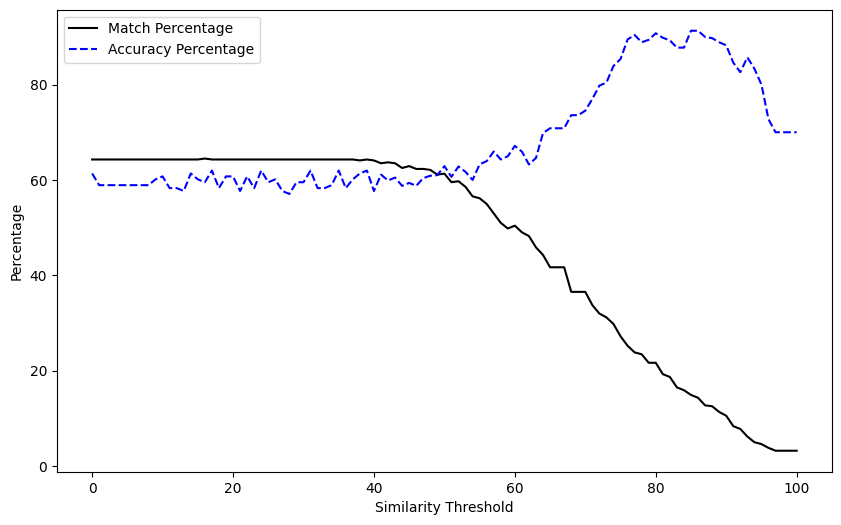

In [162]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot Match Percentage
plt.plot(georeferencing_df['similarity_score'], georeferencing_df['match_percentage'], marker='', markersize=4, linestyle='-', color='black', label='Match Percentage')

# Plot Accuracy Percentage
plt.plot(georeferencing_df['similarity_score'], georeferencing_df['accuracy'], marker='', markersize=3, linestyle='--', color='blue', label='Accuracy Percentage')

# Add labels and grid
plt.xlabel('Similarity Threshold')
plt.ylabel('Percentage')
plt.grid(False)
plt.legend()

# Save the plot
plt.savefig('plot1.png')

# Show the plot
plt.show()